# Only the mathematical trading strategy for getting the signals

In [30]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import matplotlib.pyplot as plt

## Dataset

In [31]:
df_3m = pd.read_csv('datasets/btc_3m.csv')
df_3m['datetime'] = pd.to_datetime(df_3m['datetime'])
df_3m.set_index('datetime', inplace=True)
df_3m

,open,high,low,close,volume
datetime,,,,,
2018-01-01 05:30:00,13715.65,13715.65,13666.11,13680.00,6.303815
2018-01-01 05:33:00,13679.98,13679.98,13554.44,13568.00,33.709206
2018-01-01 05:36:00,13568.00,13575.00,13501.01,13575.00,29.645987
2018-01-01 05:39:00,13539.99,13575.00,13400.01,13515.26,30.696039
2018-01-01 05:42:00,13515.26,13568.66,13473.47,13556.15,23.260966
...,...,...,...,...,...
2022-01-31 05:18:00,37919.05,37919.05,37876.94,37891.30,30.717900
2022-01-31 05:21:00,37891.30,37946.56,37870.00,37918.80,28.369420
2022-01-31 05:24:00,37918.79,37948.79,37888.88,37898.01,22.346010


In [32]:
def filter_df(df, start_date, end_date):
    subset_df = df.loc[start_date:end_date]
    return subset_df

start_date = '2018-01-01'
end_date = '2018-4-01'
filtetred_df_3m = filter_df(df_3m, start_date, end_date)
print(filtetred_df_3m.shape)
filtetred_df_3m.iloc[[0,-1],:]

(42844, 5)


,open,high,low,close,volume
datetime,,,,,
2018-01-01 05:30:00,13715.65,13715.65,13666.11,13680.00,6.303815
2018-04-01 23:57:00,6783.66,6785.00,6768.05,6768.05,211.924933


In [ ]:
filtetred_df_3m = df_3m.copy()

In [ ]:
def plot_candlestick_chart(df,num_candles=-1):
    if num_candles != -1:
        df = df.iloc[:num_candles]
    
    fig = go.Figure(data=[go.Candlestick(x=df.index,
                open=df['open'],
                high=df['high'],
                low=df['low'],
                close=df['close'])])

    # Customize the layout
    fig.update_layout(title='Candlestick chart',
                    xaxis_title='Date and Time',
                    yaxis_title='Price data',
                    xaxis_rangeslider_visible=False)

    # Show the plot
    fig.show()

In [ ]:
plot_candlestick_chart(df_3m)

### Adding the indicators

In [ ]:
def add_indicators(df):
    # SMA
    df['SMA_20'] = df['close'].rolling(window=20).mean()
    df['SMA_50'] = df['close'].rolling(window=50).mean()
    
    # RSI
    delta = df['close'].diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)

    avg_gain = gain.rolling(window=14).mean()
    avg_loss = loss.rolling(window=14).mean()

    rs = avg_gain / avg_loss
    df['RSI'] = 100 - (100 / (1 + rs))

    # Moving Average Convergence Divergence (MACD)
    short_window = 12
    long_window = 26
    signal_window = 9

    exp_short = df['close'].ewm(span=short_window, adjust=False).mean()
    exp_long = df['close'].ewm(span=long_window, adjust=False).mean()

    df['MACD'] = exp_short - exp_long
    df['Signal_Line'] = df['MACD'].ewm(span=signal_window, adjust=False).mean()

    # Bollinger Bands
    window = 20
    df['Upper_Band'] = df['SMA_20'] + 2 * df['close'].rolling(window=window).std()
    df['Lower_Band'] = df['SMA_20'] - 2 * df['close'].rolling(window=window).std()

    # ATR
    # Calculate True Range (TR)
    df['High-Low'] = df['high'] - df['low']
    df['High-PrevClose'] = abs(df['high'] - df['close'].shift(1))
    df['Low-PrevClose'] = abs(df['low'] - df['close'].shift(1))

    df['TrueRange'] = df[['High-Low', 'High-PrevClose', 'Low-PrevClose']].max(axis=1)

    # Choose the ATR period (e.g., 14 days)
    atr_period = 14

    # Calculate ATR using rolling mean
    df['ATR'] = df['TrueRange'].rolling(window=atr_period).mean()

    # Drop intermediate columns used for calculation
    df.drop(['High-Low', 'High-PrevClose', 'Low-PrevClose', 'TrueRange'], axis=1, inplace=True)

    # Removing null rows
    df = df.dropna()
    return df

In [ ]:
test_df = add_indicators(filtetred_df_3m)
print(test_df.shape)
# test_df.iloc[[0,-1],:]
test_df

In [ ]:
plt.plot(filtetred_df_3m['close'].iloc[:500],label="Close")
plt.plot(filtetred_df_3m['SMA_20'].iloc[:500],label="20 previous average")
plt.plot(filtetred_df_3m['SMA_50'].iloc[:500],label="50 previous average")
plt.legend()

## Strategy

In [42]:
# States
usd = 10000
btc = 0

# Define trading parameters
atr_factor = 1.5
take_profit_factor = 2
stop_loss = 0
target = 0
initial_close = test_df.loc[test_df.index[0],'close']
prev_resistance, resistance = initial_close,initial_close
prev_support, support = initial_close,initial_close

# Initialize columns for signals and balances
test_df.loc[:,'Signal'] = ''
test_df.loc[:,'Balance_USD'] = 10000
test_df.loc[:,'Balance_BTC'] = 0

In [43]:
# Signals
def buy(usd, btc, current_close):
    if usd > 0 and btc == 0:
        btc = (usd * 1) / current_close
        usd = 0
        return usd, btc, 'Buy'
    else:
        return usd, btc, "Not enough funds"

def sell(usd, btc, current_close):
    if btc > 0 and usd == 0:
        usd = btc * current_close
        btc = 0
        return usd, btc, 'Sell'
    else:
        return usd, btc, 'Not enough btc'

In [44]:
# Dataframe updation
def update_df(i,usd, btc, signal):
    test_df.at[test_df.index[i], 'Signal'] = signal
    test_df.at[test_df.index[i], 'Balance_USD'] = usd
    test_df.at[test_df.index[i], 'Balance_BTC'] = btc

In [45]:

# Trading loop
for i in range(0, len(test_df)):
    # Higher highs and higher lows trend tracking
    if i > 1:
        if test_df['close'][i-2] < test_df['close'][i-1] > test_df['close'][i] and test_df['close'][i-1] > resistance:
            prev_resistance = resistance
            resistance = test_df['close'][i-1]
        if test_df['close'][i-1] < support:
                current_close = test_df['close'][i]
                prev_resistance, resistance = current_close,current_close
                prev_support, support = current_close,current_close
                usd, btc, signal = sell(usd, btc, test_df['close'][i])
                # Update DataFrame
                update_df(i,usd,btc,signal)
                continue
        elif test_df['close'][i-2] > test_df['close'][i-1] < test_df['close'][i] and test_df['close'][i-1] > support:
                prev_support = support
                support = test_df['close'][i-1]
    
    # Buy condition
    if usd > 0 and btc == 0:
        if (support > prev_support 
            and resistance > prev_resistance 
            and test_df['close'][i-1] == support):
            usd, btc, signal = buy(usd, btc, test_df['close'][i])

            # Set the stop loss and target
            if usd == 0 and btc > 0:
                stop_loss = test_df['close'][i] - (atr_factor * test_df['ATR'][i])
                target = (test_df['close'][i] * 1) + (take_profit_factor * test_df['ATR'][i])
        else:
            signal = "Wait"
    # Sell condition
    elif btc > 0 and usd == 0:
        if test_df['close'][i] <= stop_loss or test_df['close'][i] >= target:
            usd, btc, signal = sell(usd, btc, test_df['close'][i])
        else:
            signal = "Hold"
    
    # Update DataFrame
    update_df(i,usd,btc,signal)

test_df

C:\Users\sanya\AppData\Local\Temp\ipykernel_10044\130952341.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if test_df['close'][i-2] < test_df['close'][i-1] > test_df['close'][i] and test_df['close'][i-1] > resistance:
C:\Users\sanya\AppData\Local\Temp\ipykernel_10044\130952341.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if test_df['close'][i-1] < support:
C:\Users\sanya\AppData\Local\Temp\ipykernel_10044\130952341.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To 

,open,high,low,close,volume,SMA_20,SMA_50,RSI,MACD,Signal_Line,Upper_Band,Lower_Band,ATR,Signal,Balance_USD,Balance_BTC
datetime,,,,,,,,,,,,,,,,
2018-01-01 07:57:00,13308.00,13323.97,13225.00,13225.00,21.656899,13360.8155,13457.1630,41.444909,-57.163918,-53.574739,13555.528164,13166.102836,93.252143,Not enough btc,10000.00000,0.000000
2018-01-01 08:00:00,13247.80,13297.05,13200.00,13268.92,17.515930,13347.7695,13448.9414,42.982268,-57.088806,-54.277553,13529.317459,13166.221541,93.683571,Not enough btc,10000.00000,0.000000
2018-01-01 08:03:00,13268.92,13349.99,13202.03,13294.55,40.327491,13336.4970,13443.4724,48.278786,-54.334815,-54.289005,13500.130723,13172.863277,98.538571,Not enough btc,10000.00000,0.000000
2018-01-01 08:06:00,13294.00,13304.98,13210.00,13225.73,19.097106,13321.7850,13436.4870,49.726941,-57.047844,-54.840773,13467.938564,13175.631436,96.450714,Not enough btc,10000.00000,0.000000
2018-01-01 08:09:00,13222.36,13245.20,13211.72,13226.10,10.836985,13310.5410,13430.7038,51.384948,-58.493803,-55.571379,13449.256783,13171.825217,93.478571,Buy,0.00000,0.756081
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-04-01 23:45:00,6826.00,6826.00,6793.00,6798.08,91.961011,6816.5630,6756.6162,55.256192,16.708673,23.296810,6856.996137,6776.129863,29.490000,Hold,0.00000,0.444750
2018-04-01 23:48:00,6798.08,6835.47,6793.00,6818.00,119.890550,6816.2365,6763.5702,55.308773,15.297459,21.696940,6856.503877,6775.969123,30.528571,Sell,3032.30871,0.000000
2018-04-01 23:51:00,6819.37,6819.38,6785.01,6799.78,104.573571,6814.8910,6769.6058,51.110387,12.564030,19.870358,6855.484690,6774.297310,31.232143,Sell,3032.30871,0.000000


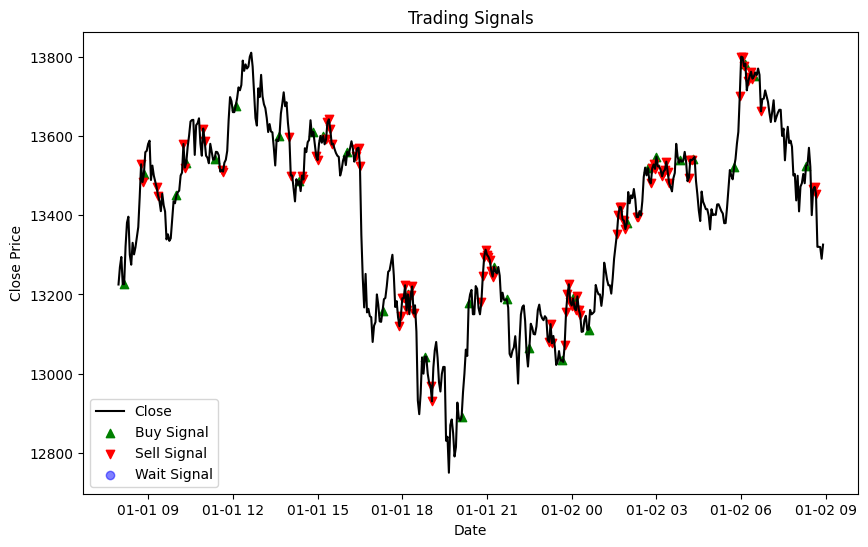

In [46]:
plot_df = test_df.iloc[:500,:]
plt.figure(figsize=(10, 6))

# Plot close values
plt.plot(plot_df.index, plot_df['close'], label='Close', color='black')

# Marking Buy signals with green upward arrows
plt.scatter(plot_df[plot_df['Signal'] == 'Buy'].index, plot_df[plot_df['Signal'] == 'Buy']['close'], label='Buy Signal', marker='^', color='g', alpha=1)

# Marking Sell signals with red downward arrows
plt.scatter(plot_df[plot_df['Signal'] == 'Sell'].index, plot_df[plot_df['Signal'] == 'Sell']['close'], label='Sell Signal', marker='v', color='r', alpha=1)

# Marking Wait signals with blue circles
plt.scatter(plot_df[plot_df['Signal'] == 'Wait'].index, plot_df[plot_df['Signal'] == 'Wait']['close'], label='Wait Signal', marker='o', color='b', alpha=0.5)

plt.title('Trading Signals')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()